# Analysis of General Public graphs





In [69]:
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import os.path as op
import sys
sys.path.append(
    '/Users/CN/Documents/Projects/Cambridge/cambridge_language_analysis/')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data Processing
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import re
# import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import networkx as nx


In [70]:
# SemanticSpeechGraph functions
from compile_graphs_dataset import get_graphs, graph_properties, exclude_empty_graphs
from graph_analysis_functions import print_bidirectional_edges, print_parallel_edges, get_parallel_edges
from word_embedding_analysis import central_words

In [71]:
# --------------------- Import graphs ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'
output_figures = op.join(graph_dir, 'figures')

graphs, filelist = get_graphs(graph_dir)
graphs, filelist = exclude_empty_graphs(graphs, filelist, be_quiet=True)



Obtained 2861 graphs. Excluded 16 empty graphs. Kept 2845 graphs.


In [73]:
# --------------------- Import graph data ---------------------------------------
df = pd.read_csv(op.join(graph_dir, 'output/graph_data_normalised.csv'))

print('Described {0} graphs.\n{1} subjects described {2} ± {3} pictures.'.format(df.shape[0], len(df.subj.unique()), round(df.subj.value_counts().mean(),2), round(df.subj.value_counts().std(),2)))

# Make subj and tat categorical
df.subj = pd.Categorical(df.subj.astype('str'))
df.tat = pd.Categorical(df.tat.astype('str'))
df.tat = df.tat.cat.rename_categories({'8': '08'})
df.tat = df.tat.cat.reorder_categories(
    ['08', '10', '13', '19', '21', '24', '28', '30'])

Described 2845 graphs.
436 subjects described 6.53 ± 2.39 pictures.


# Control for network size in Oasis data
1. Estimate relationship between number of nodes and connected component measures general public data
2. Regress association out of Oasis data

In [74]:

# --------------------- Import OASIS data ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/oasis'
oasis = pd.read_csv(op.join(graph_dir, 'output/graph_data_normalised.csv'))
oasis['group'] = pd.Categorical(oasis.group)
oasis.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'], inplace=True)




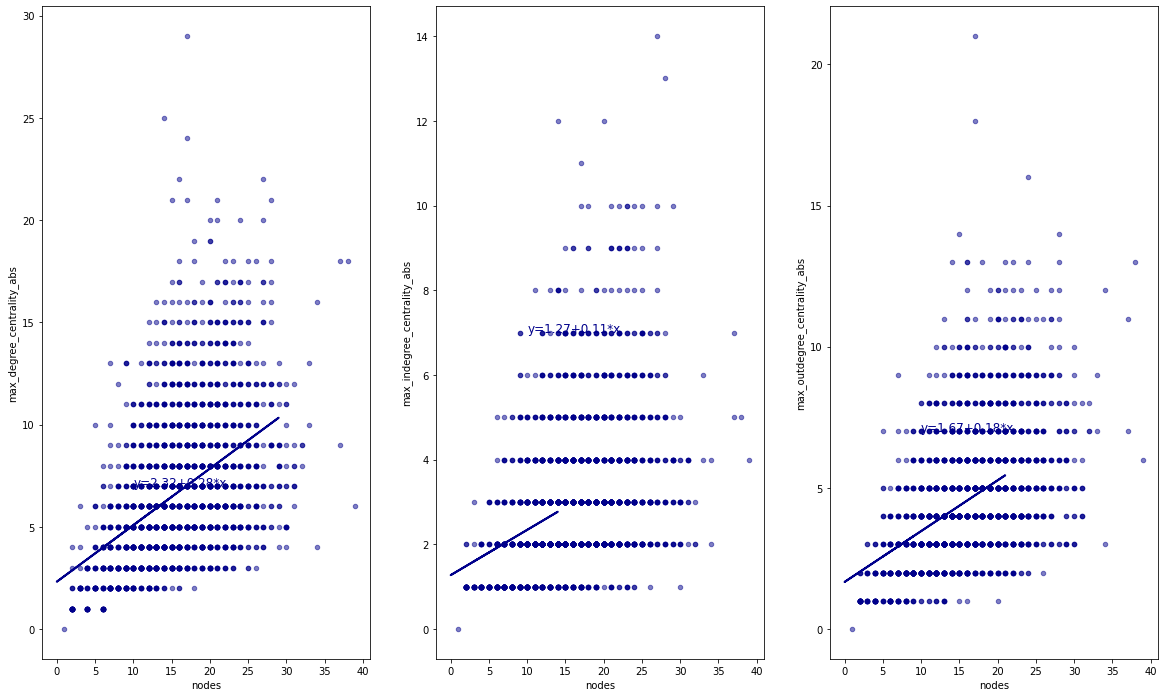

In [76]:
# Estimate relationship in general public data
nans = np.isnan(df.cc_size_med.values)
df_nonan = df[~nans]
# variables = ['connected_components', 'cc_size_med', 'cc_size_mean']
variables = ['max_degree_centrality_abs', 'max_indegree_centrality_abs', 'max_outdegree_centrality_abs']

fig = plt.figure(figsize=(20, 12))
for v,plot_variable in enumerate(variables):
    # best fit polynomial
    node_fit = np.polyfit(df_nonan.nodes, df_nonan[plot_variable], 1)
    # Predict values for Oasis
    pred_vals = np.polyval(node_fit, oasis.nodes)
    # Calculate residuals
    residuals = oasis.connected_components_normZ - pred_vals
    # Add residuals to dataframe
    oasis[plot_variable + '_res'] = residuals
    # scatter plot
    ax = plt.subplot(1,3,v+1)
    df_nonan.plot(kind='scatter', x='nodes', y=plot_variable, color='darkblue', alpha=0.5, ax = ax)
    # regression lines
    plt.plot(df_nonan[plot_variable], node_fit[0] * df_nonan[plot_variable] + node_fit[1], color='darkblue', linewidth=2)
    # regression equations
    plt.text(10, 7, 'y={:.2f}+{:.2f}*x'.format(node_fit[1], node_fit[0]), color='darkblue', size=12)




In [85]:
oasis.columns

Index(['Unnamed: 0', 'subj', 'tat', 'words', 'sentences', 'nodes', 'edges',
       'unconnected', 'average_total_degree', 'parallel_edges',
       'bidirectional_edges', 'lsc', 'lcc', 'L1', 'L2', 'L3',
       'sizes_connected_components', 'cc_size_mean', 'cc_size_med',
       'cc_size_sd', 'cc_size_max', 'connected_components',
       'max_degree_centrality', 'max_degree_node', 'max_indegree_centrality',
       'max_outdegree_centrality', 'max_indegree_centrality_value',
       'max_outdegree_centrality_value', 'max_degree_centrality_abs',
       'max_indegree_centrality_abs', 'max_outdegree_centrality_abs',
       'mean_sentence_length', 'mean_confidence', 'std_confidence', 'density',
       'diameter', 'average_shortest_path', 'clustering', 'consecutive_edges',
       'average_total_degree_normF', 'average_total_degree_normZ',
       'parallel_edges_normF', 'parallel_edges_normZ',
       'bidirectional_edges_normF', 'bidirectional_edges_normZ', 'lsc_normF',
       'lsc_normZ', 'lcc_n

In [87]:
# --------------------- Write residualised variables to csv ---------------------------------------

oasis[['subj', 'words', 'sentences', 'nodes', 'connected_components_res', 'cc_size_med_res', 'cc_size_mean_res', 'max_degree_centrality_abs_res', 'max_indegree_centrality_abs_res', 'max_outdegree_centrality_abs_res']].to_csv(op.join('/Users/CN/Dropbox/speech_graphs/oasis/output', 'graph_data_residualised.csv'))
# oasis.to_csv(op.join('/Users/CN/Dropbox/speech_graphs/oasis/output', 'graph_data_residualised_avg.csv'))


# --------------------- Average across tats ---------------------------------------
oasis_avg = (oasis.groupby((oasis.subj != oasis.subj.shift()).cumsum())
          .mean()
          .reset_index(drop=True))

# Add subj index that was dropped during averaging back into dataframe
oasis_avg['subj'] = None
for subject in oasis.subj.unique():
    # Find position where the average for words, sentences and nodes match the oasis_avg value
    match_words = oasis.query('subj == @subject').mean().words == oasis_avg.words
    match_sentences = oasis.query(
        'subj == @subject').mean().sentences == oasis_avg.sentences
    match_nodes = oasis.query(
        'subj == @subject').mean().nodes == oasis_avg.nodes
    intersection = np.logical_and(match_words, match_sentences)
    intersection = np.logical_and(intersection, match_nodes)
    oasis_avg.loc[intersection, 'subj'] = subject


oasis_avg['group'] = pd.Categorical(oasis_avg.group_n)

oasis_avg.group = oasis_avg.group.cat.rename_categories(
    {0: 'CON', -56: 'FEP', 100: 'CHR'})
oasis_avg.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'], inplace=True)
oasis_avg.group.value_counts()

# --------------------- Write residualised variables averaged across tats to csv ---------------------------------------
oasis_avg[['subj', 'words', 'sentences', 'nodes', 'connected_components_res', 'cc_size_med_res', 'cc_size_mean_res', 'max_degree_centrality_abs_res', 'max_indegree_centrality_abs_res', 'max_outdegree_centrality_abs_res']].to_csv(op.join('/Users/CN/Dropbox/speech_graphs/oasis/output', 'graph_data_residualised_avg.csv'))
